In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [147]:
fields = ['P_ROKDYP',"P_N","P_POZIOM", # wartosci filtrujace
"P_E_ZAR_STUD_P5","P_E_ZAR_NSTUD_P5","P_E_ZAR_P5", #dane o zarobkach absolwentow po 5 latach
"P_E_ZAR_DOSW_P5","P_E_ZAR_NDOSW_P5",
"P_ME_ZAR_P5","P_ME_ZAR_DOSW_P5","P_ME_ZAR_NDOSW_P5",
"P_ME_ZAR_STUD_P5","P_ME_ZAR_NSTUD_P5",
"P_E_ZAR_ETAT_P5","P_E_ZAR_ETAT_DOSW_P5","P_E_ZAR_ETAT_NDOSW_P5",
"P_E_ZAR_ETAT_STUD_P5","P_E_ZAR_ETAT_NSTUD_P5",
"P_ME_ZAR_ETAT_P5","P_ME_ZAR_ETAT_DOSW_P5","P_ME_ZAR_ETAT_NDOSW_P5",
"P_ME_ZAR_ETAT_STUD_P5","P_ME_ZAR_ETAT_NSTUD_P5",
"P_WWZ_STUD_P5","P_WWZ_NSTUD_P5","P_WWZ_P5","P_WWZ_DOSW_P5","P_WWZ_NDOSW_P5",
'P_NAZWA_UCZELNI',"P_NAZWA_KIERUNKU_PELNA","P_KIERUNEK_ID","P_FORMA","P_DZIEDZINA","P_WOJ"] #dane o uczelni i kierunku
data1 = pd.read_csv('dane/graduates-major-data.csv',sep=";",usecols=fields,decimal=',')

In [148]:
# drobna redukcja pamieci na kolumnach o pewnych wartosciach
data1["P_ROKDYP"] = data1["P_ROKDYP"].astype('int16')
data1["P_KIERUNEK_ID"] = data1["P_KIERUNEK_ID"].astype('int32')
data1["P_N"] = data1["P_N"].astype('int16')
data1["P_POZIOM"] =data1["P_POZIOM"].astype("category")
# problem z zamiana P_FORMA, przy grupowaniu powoduje memmory leak
# data1["P_FORMA"] =data1["P_POZIOM"].astype("category")
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41792 entries, 0 to 41791
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   P_ROKDYP                41792 non-null  int16   
 1   P_KIERUNEK_ID           41792 non-null  int32   
 2   P_POZIOM                41792 non-null  category
 3   P_FORMA                 41792 non-null  object  
 4   P_N                     41792 non-null  int16   
 5   P_E_ZAR_STUD_P5         2736 non-null   float64 
 6   P_E_ZAR_NSTUD_P5        7194 non-null   float64 
 7   P_E_ZAR_P5              14190 non-null  float64 
 8   P_E_ZAR_DOSW_P5         9247 non-null   float64 
 9   P_E_ZAR_NDOSW_P5        10511 non-null  float64 
 10  P_ME_ZAR_STUD_P5        2736 non-null   float64 
 11  P_ME_ZAR_NSTUD_P5       7194 non-null   float64 
 12  P_ME_ZAR_P5             14190 non-null  float64 
 13  P_ME_ZAR_DOSW_P5        9247 non-null   float64 
 14  P_ME_ZAR_NDOSW_P5     

In [149]:
# dane o absolwentach z roku 2014 i 2015 roku 
data1 = data1[(data1['P_ROKDYP']==2014) | (data1['P_ROKDYP']==2015)]
# studia magisterskie lub jednolitemagisterskie
data1 = data1[(data1['P_POZIOM']=="JM") | (data1['P_POZIOM']=="2")]

In [150]:
# duzo pustych wartosci jesli chodzi o informacje 
##### zastanowic sie nad wyborem
# -P_E_ZAR_P5, P_ME_ZAR_P5, P_WWZ_P5, maja najmniej brakujacych informacji
# P_E_ZAR_ETAT_P5,P_ME_ZAR_ETAT_P5
nullvalues = data1.isna().sum()
nullvalues[nullvalues > 0]

P_E_ZAR_STUD_P5           5013
P_E_ZAR_NSTUD_P5          3032
P_E_ZAR_P5                  16
P_E_ZAR_DOSW_P5           1541
P_E_ZAR_NDOSW_P5          1313
P_ME_ZAR_STUD_P5          5013
P_ME_ZAR_NSTUD_P5         3032
P_ME_ZAR_P5                 16
P_ME_ZAR_DOSW_P5          1541
P_ME_ZAR_NDOSW_P5         1313
P_E_ZAR_ETAT_STUD_P5      5097
P_E_ZAR_ETAT_NSTUD_P5     3037
P_E_ZAR_ETAT_P5             22
P_E_ZAR_ETAT_DOSW_P5      1677
P_E_ZAR_ETAT_NDOSW_P5     1492
P_ME_ZAR_ETAT_STUD_P5     5097
P_ME_ZAR_ETAT_NSTUD_P5    3037
P_ME_ZAR_ETAT_P5            22
P_ME_ZAR_ETAT_DOSW_P5     1677
P_ME_ZAR_ETAT_NDOSW_P5    1492
P_WWZ_STUD_P5             5013
P_WWZ_NSTUD_P5            3032
P_WWZ_P5                    16
P_WWZ_DOSW_P5             1541
P_WWZ_NDOSW_P5            1313
P_DZIEDZINA                 21
dtype: int64

In [151]:
# zgrupowanie po kierunku na uczelni z podzialem na stacjonarne i niestacjonarne,
# liczba osob na kierunku zsumowana z lat 2014 i 2015, średnia płaca roczników uśredniona
# "P_DZIEDZINA","P_WOJ"
data1 = data1.groupby(["P_NAZWA_UCZELNI","P_KIERUNEK_ID","P_NAZWA_KIERUNKU_PELNA","P_FORMA","P_DZIEDZINA","P_WOJ"]).agg({
    "P_N" :'sum',"P_E_ZAR_P5":'mean',"P_ME_ZAR_P5":'mean',"P_E_ZAR_ETAT_P5":'mean',"P_ME_ZAR_ETAT_P5":'mean',"P_ME_ZAR_P5":'mean',"P_WWZ_P5":'mean'
})

In [152]:
# wybranie kierunkow posiadajacych conajmniej 30 absolwentow
data1 = data1[(data1['P_N']>=30)].reset_index()
# przypisanie wartosciom numerycznym wojewodztw wartosci tekstowe
wojewodztwa = {
    14:"Mazowieckie", 12:"Małopolskie", 24:"Śląskie",30:"Wielkopolskie",
    2:"Dolnoślaśkie",22:"Pomorskie",6:"Lubelskie",10:"Łódzkie",
    4:"Kujawsko-Pomorskie",32:"Zachodniopomorskie",18:"Podkarpackie",
    20:"Podlaskie",28:"Warmińsko-mazurskie",16:"Opolskie",
    26:"Świętokrzyskie", 8:"Lubuskie"
}
data1['P_WOJ']=data1['P_WOJ'].map(wojewodztwa)

In [153]:
##
"""
    Przeglad danych,
    1. Ile jest kierunkow stacjonarnych i niestacjonarnych
    2. Dystrybucja kategorii? byla chyba taka kolumna
    3. Zrobić moze te takie przedziały srednich by zobaczyc jak sie rozkladaja
        to sie qcut (przedzialow pierwiastek z n)

    Chyba w tabeli te rzeczy najlepiej ukazac, wykresy nie pokazuja raczje nic ciekawego
    i problematyka zwiazana z dodaniem opisu zmiennej
    1. Najlepiej zarabiajace w skali kraju
    2. Najlepiej zarabiajace w skali wojewodztwa
"""

'\n    Przeglad danych,\n    1. Ile jest kierunkow stacjonarnych i niestacjonarnych\n    2. Dystrybucja kategorii? byla chyba taka kolumna\n    3. Zrobić moze te takie przedziały srednich by zobaczyc jak sie rozkladaja\n        to sie qcut (przedzialow pierwiastek z n)\n\n    Chyba w tabeli te rzeczy najlepiej ukazac, wykresy nie pokazuja raczje nic ciekawego\n    i problematyka zwiazana z dodaniem opisu zmiennej\n    1. Najlepiej zarabiajace w skali kraju\n    2. Najlepiej zarabiajace w skali wojewodztwa\n'

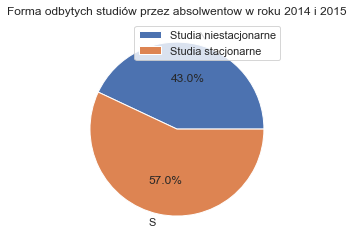

In [234]:
# Suma liczby absolwentow na studiach stacjonarnych i niestacjonarnych
formdata = data1.groupby(['P_FORMA']).agg({"P_N":"sum"})
formdata=formdata.reset_index()

plt.pie(formdata['P_N'],labels=formdata['P_FORMA'],autopct='%1.1f%%')
plt.legend(['Studia niestacjonarne',"Studia stacjonarne"],loc="best")
plt.title("Forma odbytych studiów przez absolwentow w roku 2014 i 2015")
plt.savefig('Udzial1.png', dpi=400, bbox_inches='tight')
plt.show()

In [225]:
# 10 najlepszych kierunkow ze wzgleud na srednie zarobki
test = data1.sort_values(by="P_E_ZAR_P5",ascending=False).iloc[:10]
test

,P_NAZWA_UCZELNI,P_KIERUNEK_ID,P_NAZWA_KIERUNKU_PELNA,P_FORMA,P_DZIEDZINA,P_WOJ,P_N,P_E_ZAR_P5,P_ME_ZAR_P5,P_E_ZAR_ETAT_P5,P_ME_ZAR_ETAT_P5,P_WWZ_P5
42,Akademia Górniczo-Hutnicza im. Stanisława Stas...,13613,"Informatyka, studia stacjonarne drugiego stopn...",S,Dziedzina nauk inżynieryjno-technicznych,Małopolskie,170,14338.935,15177.510,14729.985,15271.215,2.715
38,Akademia Górniczo-Hutnicza im. Stanisława Stas...,9637,"Informatyka stosowana, studia stacjonarne drug...",S,Dziedzina nauk ścisłych i przyrodniczych,Małopolskie,64,13557.190,12756.725,13809.405,13025.490,2.625
1113,Uniwersytet Jagielloński w Krakowie,7851,"Informatyka, studia stacjonarne drugiego stopn...",S,Dziedzina nauk ścisłych i przyrodniczych,Małopolskie,89,13289.935,12326.155,13431.050,12345.180,2.525
786,Polsko-Japońska Akademia Technik Komputerowych,129464,"Informatyka, studia niestacjonarne drugiego st...",N,Dziedzina nauk inżynieryjno-technicznych,Mazowieckie,36,13197.790,13586.030,13191.160,13586.030,2.050
633,Politechnika Warszawska,122827,"Informatyka, studia stacjonarne drugiego stopn...",S,Dziedzina nauk inżynieryjno-technicznych,Mazowieckie,132,13053.660,13216.630,13232.415,13091.680,2.200
785,Polsko-Japońska Akademia Technik Komputerowych,2070,"Informatyka, studia niestacjonarne drugiego st...",N,Dziedzina nauk inżynieryjno-technicznych,Mazowieckie,43,12999.780,14264.420,12855.930,14264.420,2.210
621,Politechnika Warszawska,107604,"Informatyka, studia stacjonarne drugiego stopn...",S,Dziedzina nauk inżynieryjno-technicznych,Mazowieckie,84,12676.285,14038.355,13594.865,14665.190,2.160
2310,Wyższa Szkoła Informatyki Stosowanej i Zarządz...,127181,"Zarządzanie, studia niestacjonarne drugiego st...",N,Dziedzina nauk społecznych,Mazowieckie,42,12493.655,9125.700,12507.370,9007.645,2.130
787,Polsko-Japońska Wyższa Szkoła Technik Komputer...,129464,"Informatyka, studia niestacjonarne drugiego st...",N,Dziedzina nauk inżynieryjno-technicznych,Mazowieckie,60,12482.410,12740.780,12272.910,12205.650,2.230
1807,Uniwersytet Warszawski,6749,"Informatyka, studia stacjonarne drugiego stopn...",S,Dziedzina nauk ścisłych i przyrodniczych,Mazowieckie,103,12385.465,11843.415,13445.020,13113.945,2.005


In [155]:
test["uczelnia_kierunek"] = test["P_NAZWA_UCZELNI"]+"\n"+test["P_NAZWA_KIERUNKU_PELNA"]
